# A bird's eye view of optimization


## Math background

### Matrices and vectors

Some `python` subtleties:

- Vectors are always displayed as row (not column) vectors.

- Shape of matrices are tuples of the form `(m,n)`

- Shape of a vector is a tuple of the form `(n,)`

To perform matrix multiplication use `@` not `*`.  The latter performs componentwise multiplication of two matrices of the same size.

In [1]:
import numpy as np
m = 4; n = 3; p = 2
A = np.random.randn(m,n)
B = np.random.randn(n,p)
x = np.random.randn(n)
AB = A@B
Ax = A@x
print("Shape of AB:", AB.shape)
print("Shape of Ax:", Ax.shape)
print("A = \n",A)
print("B = \n",B)
print("AB = \n",AB)
print("Ax = \n",Ax)

Shape of AB: (4, 2)
Shape of Ax: (4,)
A = 
 [[ 0.58346667 -0.62498365  0.57706955]
 [-1.86078793 -0.31489902 -1.78621105]
 [ 0.36456894 -0.24353427 -2.05074233]
 [-0.83852148  1.75976571  1.41611547]]
B = 
 [[ 0.6079218  -0.40208807]
 [ 0.03961986 -1.74088041]
 [ 0.20762046  0.69698122]]
AB = 
 [[ 0.44975179  1.25562345]
 [-1.51454376  0.0514466 ]
 [-0.21379546 -1.15195368]
 [-0.14601926 -1.73937628]]
Ax = 
 [-0.82483098  4.33377854  0.3551031  -0.37152951]


## Products of vectors

Suppose $a,b\in \mathbb{R}^n$.  

To compute $a^T b \in \mathbb{R}$ use `np.dot()` or `np.inner()`.

To compute $a b^T\in \mathbb{R}^{n\times n}$ use `np.outer()`.

In [2]:
a=np.random.randn(3); b=np.random.randn(3); 
print("a = ", a)
print("b = ", b)
print("a*b = ", a*b)
print("np.dot(a,b) = ", np.dot(a,b))
print("np.inner(a,b) = ", np.inner(a,b))
print("np.outer(a,b) = \n", np.outer(a,b))

a =  [0.04057283 0.91064393 1.13171672]
b =  [-0.42528416  0.60185364  0.04104227]
a*b =  [-0.01725498  0.54807437  0.04644823]
np.dot(a,b) =  0.5772676135630723
np.inner(a,b) =  0.5772676135630723
np.outer(a,b) = 
 [[-0.01725498  0.0244189   0.0016652 ]
 [-0.38728244  0.54807437  0.0373749 ]
 [-0.4813012   0.68112783  0.04644823]]


## Unconstrained optimization

We can minimize $\frac{1}{2} \|Ax-b\|_2^2$  via Fermat's rule: $\bar x = (A^TA)^{-1}A^Tb$ or via `cvxpy`. 

In [3]:
m = 5 ; n = 3
A = np.random.randn(m,n) ; b = np.random.randn(m) 
ATA = A.T@A
ATb = A.T@b
x = np.linalg.solve(ATA,ATb)
print(x)

[4.5159774  4.06314403 0.75790746]


Set up the problem in `cvxpy`.  For installation instructions and related information on `cvxpy` visit https://www.cvxpy.org

To formulate the problem you need to define variables, objective, and constraints.

In [4]:
# Run the following line if you are using Colab and want to use the fancy solver Gurobi
# !pip install gurobipy
import cvxpy as cp
x = cp.Variable(n)
objective = cp.Minimize(0.5*cp.sum_squares(A@x-b))
prob = cp.Problem(objective)

/Users/javipena/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Next, solve the problem and display the solution.  

We can use the fancy solver `gurobi` or `mosek` if available.  If not, we can use the default solver via `prob.solve()` 

To see all available solvers use `cvxpy.installed_solvers()`

In [5]:
#prob.solve()
prob.solve(solver = cp.MOSEK)
print(x.value)

[4.5159774  4.06314403 0.75790746]


In [6]:
cp.installed_solvers()

['CVXOPT',
 'ECOS',
 'ECOS_BB',
 'GLPK',
 'GLPK_MI',
 'GUROBI',
 'MOSEK',
 'OSQP',
 'SCIPY',
 'SCS']

As an additional sanity check, verify that the gradient is indeed zero.

In [7]:
gx = A.T@(A@x.value - b)
print(gx)

[-3.40072390e-09  2.54994800e-09 -3.84957273e-09]


Repeat the above for $\frac{1}{2} \|Ax-b\|_2^2 + \lambda \|x\|_2^2 $.

In [8]:
lam = 0.1
x = np.linalg.solve(ATA+2*lam*np.identity(n),ATb)
print(x)

[1.95114149 0.99751027 0.28317166]


In [9]:
x = cp.Variable(n)
objective = cp.Minimize(0.5*cp.sum_squares(A@x-b)+lam*cp.sum_squares(x))
prob = cp.Problem(objective)
prob.solve(solver=cp.MOSEK)
print(x.value)

[1.95112964 0.99750688 0.28317383]


## Linear programming

### Porfolio construction example.

Linear programming model for fund allocation.  We want to solve
$$ 
\begin{array}{rl} \max_x & r^Tx \\
& Ax = b \\
& Dx \ge d\\
& x\ge 0
\end{array}
$$
for $r,A,b,D,d$ as below.

Define the problem data.

In [10]:
n = 4
r = np.array([0.10, 0.15, 0.16, 0.08]) 
A = np.array([1, 1, 1, 1,]) 
b = 80 
D = np.array([[0.5, 0.3, 0.25, 0.6],
              [0.3, 0.1, 0.4,  0.2],
              [0.2, 0.6, 0.35, 0.2]]) 
d = np.array([28,24,12]) 

Set up the problem in `cvxpy`.  

To formulate the problem you need to define variables, objective, and constraints.

In [11]:
import cvxpy as cp
x = cp.Variable(n)
objective = cp.Maximize(r.T@x)
constraints = [A@x == b,D@x>=d, x>=0]
prob = cp.Problem(objective, constraints)

Next, solve the problem.  

We can use the fancy solver `gurobi` or `mosek` if available.  
If not, we can use the default solver via `prob.solve()` 

In [12]:
#prob.solve()
prob.solve(solver = cp.GUROBI)

Academic license - for non-commercial use only - expires 2025-06-28
Using license file /Users/javipena/gurobi.lic


10.989473684210527

Display optimal value and optimal solution.  

In [13]:
print("\nThe optimal value is", prob.value)
print("An optimal solution is")
print(x.value)


The optimal value is 10.989473684210527
An optimal solution is
[ 0.         12.63157895 46.31578947 21.05263158]


As a sanity check, verify that the constraints hold.

In [14]:
print("Ax = ",A@x.value)
print("Dx = ",D@x.value)

Ax =  80.0
Dx =  [28. 24. 28.]


## $\ell_1$ minimization

The $\ell_1$ minimization problem to find a sparse solution to $Ax=b$.

First generate $A,b$ such that $Ax=b$ has a sparse solution.

In [15]:
n = 40; k = 5; m = 20
y = np.random.rand(n)
ysort = np.sort(y)
ysort[-k]
y = y*(y>=ysort[-k])
A = np.random.randn(m,n)
b = A@y

In [16]:
x = cp.Variable(n)
u = cp.Variable(n)
objective = cp.Minimize(cp.sum(u))
constraints = [A@x==b, x<=u, -x<=u]
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK)

4.5162885312965795

In many cases we recover the original sparse $y$ solution.

norm of the difference =  1.2294253301399186e-13


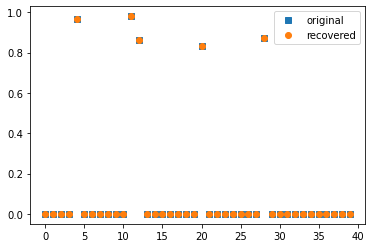

In [17]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

print("norm of the difference = ", np.linalg.norm(y-x.value))
plt.plot(y,'s',label='original') ; plt.plot(x.value,'o',label='recovered')
plt.legend()
plt.show()

`cvxpy` also allows us to formulate the $\ell_1$ minimization directly via the `cp.norm` function.

norm of the difference =  1.2294253301399186e-13


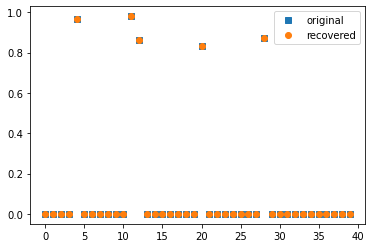

In [18]:
x = cp.Variable(n)
objective = cp.Minimize(cp.norm(x,1))
constraints = [A@x==b]
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK)
print("norm of the difference = ", np.linalg.norm(y-x.value))
plt.plot(y,'s',label='original') ; plt.plot(x.value,'o',label='recovered')
plt.legend()
plt.show()

## Lasso regression

In general, the lasso model $\min_x \left\{ \frac{1}{2}\|Ax-b\|_2^2 + \lambda \cdot \|x\|_1\right\}$ can only be solved numerically.

First generate $A\in \mathbb{R}^{m\times n}, b\in\mathbb{R}^m$.  To make it more interesting, pick $n > m$.


In [19]:
m=50; n=100
A = np.random.randn(m,n)
b = np.random.randn(m)

Now solve the lasso model.

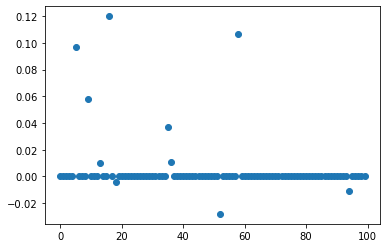

In [20]:
lam = 10
x = cp.Variable(n)
u = cp.Variable(n)
objective = cp.Minimize(0.5*cp.sum_squares(A@x-b)+lam*cp.sum(u))
constraints = [x<=u, -x<=u]
prob = cp.Problem(objective,constraints)
prob.solve(solver=cp.MOSEK)
plt.plot(x.value,'o')
plt.show()

Again, `cvxpy` allows us to formulate the $\ell_1$ minimization directly.

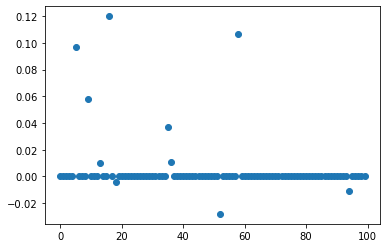

In [21]:
x = cp.Variable(n)
objective = cp.Minimize(0.5*cp.sum_squares(A@x-b)+lam*cp.norm(x,1))
prob = cp.Problem(objective)
prob.solve(solver=cp.MOSEK)
plt.plot(x.value,'o')
plt.show()

## Mean-variance models

Suppose asset returns follow a one-factor model: $r_i = \beta_i \cdot f + u_i$ for $i=1,\dots,n$.


In [22]:
n = 5
beta = 0.5 + np.arange(n)/(n-1)
V = np.outer(beta,beta)+np.identity(n)
mu = 0.1*beta

First find fully-invested, long-only, portfolio of minimum variance, that is,
$$
\begin{array}{rl}
min_x & x^TVx \\
& 1^Tx = 1\\
& x\ge 0.
\end{array}
$$

As you may intuit, the portfolio is tilted toward low beta assets.

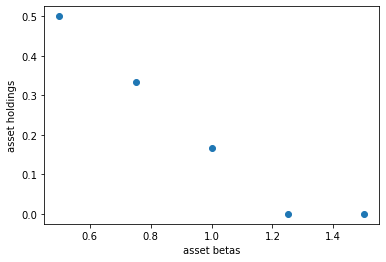

In [23]:
x = cp.Variable(n)
objective = cp.Minimize(cp.quad_form(x,V))
constraints = [cp.sum(x)==1, x>=0]
prob = cp.Problem(objective,constraints)
prob.solve(solver=cp.MOSEK)
fig, ax = plt.subplots()
ax.plot(beta,x.value,'o')
ax.set_xlabel("asset betas")
ax.set_ylabel("asset holdings")
plt.show()

Next, find fully-invested, long-only, efficient portfolio for some risk aversion $\gamma>0:$

$$
\begin{array}{rl}
min_x & \frac{\gamma}{2} x^TVx - \mu^T x\\
& 1^Tx = 1\\
& x\ge 0.
\end{array}
$$

For small $\gamma$ the portfolio is tilted toward large beta assets. 

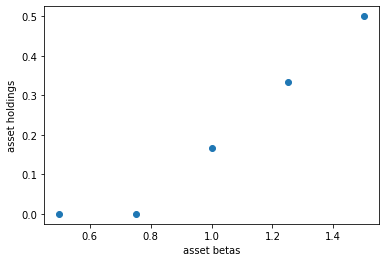

In [24]:
x = cp.Variable(n)
gamma = 0.05
objective = cp.Minimize(0.5*gamma*cp.quad_form(x,V)-mu.T@x)
constraints = [cp.sum(x)==1, x>=0]
prob = cp.Problem(objective,constraints)
prob.solve(solver=cp.MOSEK)
fig, ax = plt.subplots()
ax.plot(beta,x.value,'o')
ax.set_xlabel("asset betas")
ax.set_ylabel("asset holdings")
plt.show()

Now generate and visualize a bunch of portfolios on the efficient frontier.

In [25]:
N = 20
gammamin = sum(np.linalg.solve(V,mu))/5
gammamax = sum(np.linalg.solve(V,mu))*100
gamma = 1/np.linspace(1/gammamax,1/gammamin,N)
sigmafrontier = np.zeros(N)
mufrontier = np.zeros(N)

xfrontier = np.empty((n,N))
for k in range(N):
    x = cp.Variable(n)
    objective = cp.Minimize(0.5*gamma[k]*cp.quad_form(x,V)-mu.T@x)
    constraints = [cp.sum(x)==1, x>=0]
    prob = cp.Problem(objective,constraints)
    prob.solve(solver=cp.MOSEK)
    xfrontier[:,k] = x.value
    mufrontier[k] = mu.T@x.value
    sigmafrontier[k] = (x.value.T@V@x.value)**0.5

Visualize the efficient frontier: the holdings of the efficient portfolios.

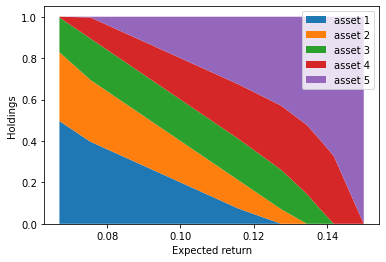

In [26]:
names = list(map(lambda x: 'asset '+str(x),np.arange(n)+1))
fig, ax = plt.subplots()
ax.stackplot(mufrontier,xfrontier,labels=names)
ax.set_xlabel("Expected return")
ax.set_ylabel("Holdings")
plt.legend()
plt.show()

Visualize also the $\mu$ versus $\sigma$ plot for portfolios on the efficient frontier.

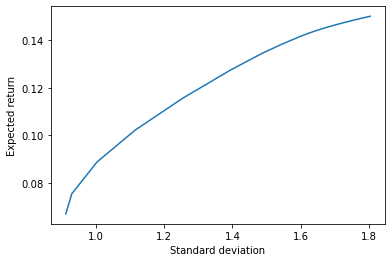

In [27]:
fig,ax = plt.subplots()
ax.plot(sigmafrontier,mufrontier)
ax.set_xlabel("Standard deviation")
ax.set_ylabel("Expected return")
plt.show()

## Integer programming

In [28]:
w = np.array([7,10,6,3]) 
v = np.array([9,11,7,4])
W = 19

In [29]:
n = len(v)
x = cp.Variable(n,boolean=True)
prob = cp.Problem(cp.Maximize(v.T@x),
                 [w.T@x <= W])
prob.solve(solver=cp.MOSEK)
print(x.value)

[0. 1. 1. 1.]


In [30]:
n = 100
v = np.round(100*np.random.rand(n))
w = np.round(100*np.random.rand(n))
W = np.sum(w)//2
n = len(v)
x = cp.Variable(n,boolean=True)
prob = cp.Problem(cp.Maximize(v.T@x),
                 [w.T@x <= W])
prob.solve(solver=cp.MOSEK)
print('Number of selected items = ', np.sum(x.value>0))

Number of selected items =  66


Here is a mixed integer programming formulation for benchmark tracking tested on randomly generated instances.  Observe that the problem can be easily solved for  $n\le 30$ but it becomes much more challenging for larger values of $n$.

In [31]:
n = 20
k = n//2
L = np.random.randn(n,n)
V = L@L.T
x = cp.Variable(n)
xB = np.ones(n)/n
y = cp.Variable(n,boolean=True)
obj = cp.Minimize(cp.quad_form(x-xB,V))
constraints = [cp.sum(x)==1,x>=0,x<=y,cp.sum(y)<=10]
prob = cp.Problem(obj,constraints)
prob.solve(solver=cp.MOSEK)
print('Number of nonzero holdings = ', np.sum(x.value>0))

Number of nonzero holdings =  10
